# Welcome to the *softspot* getting-started guide

We first import everything we need.

In [93]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
from os.path import join
import pickle
import matplotlib.pyplot as plt

from softspot.softspot import SoftSpot

%matplotlib inline

We load example data of a two-dimensional high-parent-temperature polydisperse inverse-power-law glass,
consisting of 4096 particles.

In [94]:
data_folder = "../data"
data_file = join(data_folder, "ipl_swap2D_N4096_T0.7.npz") 
data = np.load(data_file, allow_pickle=True)

hessian = data['hessian'][()]
pos = data['pos']
ndim = data['ndim']
npart = data['npart']

For reference, we first find the lowest non-translational *harmonic mode* $\psi$.

In [95]:
eigenvalues, eigenvectors = eigs(hessian, k=3, which='LM', sigma=0, tol=0)
# Throw away infinitesimal imaginary part and sort.
eigenvalues  = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
idx = eigenvalues.argsort()
eigenvalues   = eigenvalues[idx]
eigenvectors  = eigenvectors[:,idx]

psi = eigenvectors[:, 2]
kappa_psi = eigenvalues[2]

print("The lowest harmonic mode has stiffness %g." % kappa_psi)

The lowest harmonic mode has stiffness 0.0765369.


Now, we find the corresponding *pseudo-harmonic mode* $\pi$ with conjugate gradient (cg) minimization.

In [ ]:
softspot = SoftSpot(ndim=ndim, npart=npart, hessian=hessian)
result_cg = softspot.find(psi, mode='cg', options={'tol': 1e-10})

pi = result_cg['pi']
kappa_pi = result_cg['kappa']

print("Converged: %s.\nThe corresponding pseudo-harmonic mode has stiffness %g." % (result_cg['converged'], result_cg['kappa']))

We verify that we find the same result by repeatedly applying the mapping (Eq. 4 of the paper).

In [97]:
result_mapping = softspot.find(psi, mode='mapping', options={'tol': 1e-10})

print("Converged: %s.\nThe corresponding pseudo-harmonic mode has stiffness %g.\nThis matches the result from the CG minimization: %s." % (result_mapping['converged'], result_mapping['kappa'], np.isclose(result_cg['kappa'], result_mapping['kappa'])))

Converged: True.
The corresponding pseudo-harmonic mode has stiffness 0.160452.
This matches the result from the CG minimization: True.


We can also start from a random initial vector, which will possibly result in a different pseudo-harmonic mode $\pi$.

In [98]:
random_init = np.random.rand((ndim*npart))
result_random = softspot.find(random_init, mode='cg', options={'tol': 1e-10})

print("Converged: %s.\nThe pseudo-harmonic mode, found by starting from a random initial vector, has stiffness %g." % (result_random['converged'], result_random['kappa']))

Converged: True.
The pseudo-harmonic mode, found by starting from a random initial vector, has stiffness 4.4209.


We plot the harmonic and pseudo-harmonic modes side-by-side. It is clear that the pseudo-harmonic mode does not hybridize with phonons --- contrary to the harmonic mode --- and correctly captures the soft spot.

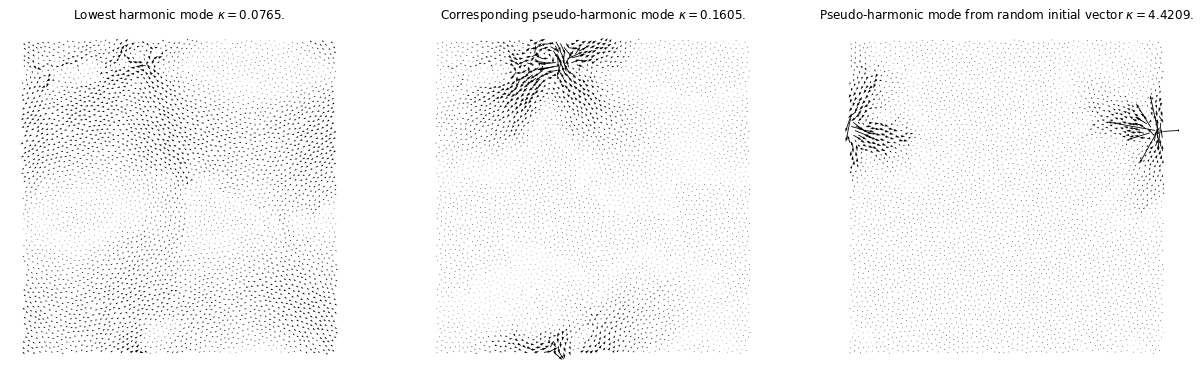

In [100]:
# Function to render modes.
def render_field(ax, r, u, color='k', scale=1):
    u = np.reshape(u, r.shape)
    ax.quiver(r[:, 0], r[:, 1], u[:, 0], u[:, 1], angles='xy', scale_units='xy', scale=scale, color=color)
    
    ax.axis('off')
    ax.set_aspect('equal')

    
plt.figure(figsize=(21, 7))
nrow = 1
ncol = 3
ax1 = plt.subplot(nrow, ncol, 1)
ax2 = plt.subplot(nrow, ncol, 2)
ax3 = plt.subplot(nrow, ncol, 3)
scale = 0.03

render_field(ax1, pos, psi, scale=scale)
render_field(ax2, pos, pi,  scale=scale)
render_field(ax3, pos, result_random['pi'],  scale=scale)

ax1.set_title("Lowest harmonic mode $\kappa = %.4f$." % kappa_psi);
ax2.set_title("Corresponding pseudo-harmonic mode $\kappa = %.4f$." % kappa_pi);
ax3.set_title("Pseudo-harmonic mode from random initial vector $\kappa = %.4f$." % result_random['kappa']);